In [1]:
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import glob, warnings
from sklearn.metrics import confusion_matrix, classification_report
from datasets import load_dataset
from transformers import ViTFeatureExtractor, AutoModelForImageClassification
from datasets import load_metric
from transformers import TrainingArguments


import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


use_cuda = torch.cuda.is_available()
     

warnings.filterwarnings('ignore')


2023-01-02 22:05:44.488738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train = load_dataset('/local/data1/chash345/train')
valid = load_dataset('/local/data1/chash345/valid')
test = load_dataset('/local/data1/chash345/test')

Resolving data files:   0%|          | 0/2600 [00:00<?, ?it/s]

Using custom data configuration train-5ba040123c4f7080
Found cached dataset imagefolder (/home/chash345/.cache/huggingface/datasets/imagefolder/train-5ba040123c4f7080/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/870 [00:00<?, ?it/s]

Using custom data configuration valid-1603420759c35bdb
Found cached dataset imagefolder (/home/chash345/.cache/huggingface/datasets/imagefolder/valid-1603420759c35bdb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/864 [00:00<?, ?it/s]

Using custom data configuration test-1f68a239285f9c45
Found cached dataset imagefolder (/home/chash345/.cache/huggingface/datasets/imagefolder/test-1f68a239285f9c45/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
np.count_nonzero(train['train']['label'])

2080

In [4]:
set(train['train']['label'])

{0, 1}

In [5]:
train['train'][2555]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2990x2990>,
 'label': 1}

In [6]:
model_name_or_path = 'google/vit-base-patch32-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [7]:
example_feature = feature_extractor(
    train['train'][100]['image'],
    return_tensors = 'pt'
)

In [8]:
example_feature

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [9]:
example_feature['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
X_train = torch.FloatTensor([0., 1., 2.])
X_train.is_cuda


False

In [12]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

# %%
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

_test_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [_test_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# %%
prepared_train = train['train'].with_transform(train_transforms)
prepared_valid = valid['train'].with_transform(val_transforms)
prepared_test = test['train'].with_transform(test_transforms)

# %%
prepared_train

# %%
prepared_valid

# %%
prepared_test

Parameter 'transform'=<function train_transforms at 0x7f7c48394550> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Dataset({
    features: ['image', 'label'],
    num_rows: 864
})

In [13]:
#prepared_test.set_format(type=prepared_test.format["type"], columns=list(prepared_test.features.keys()), transform= preprocess)

In [14]:
def collate_fn(batch):
    return{
        'pixel_values':torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [15]:
metric = load_metric('accuracy')

def compute_metrics(p):
    return metric.compute(
        predictions = np.argmax(p.predictions, axis=1),
        references = p.label_ids
    )

In [16]:
training_args = TrainingArguments(
    output_dir= '/local/data1/chash345/vit32_w_augment_model',
    seed=100,
    per_device_train_batch_size=16,
    evaluation_strategy='steps',
    num_train_epochs=25,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_pin_memory=False

)

In [17]:
from transformers import ViTForImageClassification

labels = train['train']['label']

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels)
).to('cuda')

Some weights of the model checkpoint at google/vit-base-patch32-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_valid,
    tokenizer=feature_extractor
)

In [20]:
model_results = trainer.train()

trainer.save_model()
trainer.log_metrics('train', model_results.metrics)
trainer.save_metrics('train', model_results.metrics)

trainer.save_state()

***** Running training *****
  Num examples = 2600
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 815
  Number of trainable parameters = 87798056


Step,Training Loss,Validation Loss,Accuracy
100,0.708800,0.657291,0.798851
200,0.429700,0.492501,0.808046
300,0.542700,0.493088,0.798851
400,0.298600,0.426059,0.832184
500,0.159800,0.396225,0.840230
600,0.156600,0.440261,0.855172
700,0.044100,0.498598,0.850575
800,0.122500,0.503367,0.845977


***** Running Evaluation *****
  Num examples = 870
  Batch size = 8
Saving model checkpoint to ../checkpoint-100
Configuration saved in ../checkpoint-100/config.json
Model weights saved in ../checkpoint-100/pytorch_model.bin
Image processor saved in ../checkpoint-100/preprocessor_config.json
Deleting older checkpoint [../checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 870
  Batch size = 8
Saving model checkpoint to ../checkpoint-200
Configuration saved in ../checkpoint-200/config.json
Model weights saved in ../checkpoint-200/pytorch_model.bin
Image processor saved in ../checkpoint-200/preprocessor_config.json
Deleting older checkpoint [../checkpoint-800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 870
  Batch size = 8
Saving model checkpoint to ../checkpoint-300
Configuration saved in ../checkpoint-300/config.json
Model weights saved in ../checkpoint-300/pytorch_model.bin
Image processor saved in ../checkpoi

***** train metrics *****
  epoch                    =         5.0
  total_flos               = 960056791GF
  train_loss               =       0.608
  train_runtime            =  2:27:38.94
  train_samples_per_second =       1.467
  train_steps_per_second   =       0.092


In [30]:
model = ViTForImageClassification.from_pretrained('/local/data1/chash345/vit32_w_augment_model/checkpoint-4000', num_labels=2, ignore_mismatched_sizes=True ).to('cuda')

    

training_args = TrainingArguments(
    output_dir= '/local/data1/chash345/vit32_w_augment_model/',
    per_device_train_batch_size=1,
    num_train_epochs=1,
    evaluation_strategy='steps',
    save_strategy='steps',
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    do_predict=True,
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    eval_dataset=prepared_test
)
#trainer = Trainer(model=model)
#trainer.model = model.cuda()
prediction_test = trainer.predict(prepared_test)

loading configuration file /local/data1/chash345/vit32_w_augment_model/checkpoint-4000/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch32-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 32,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0"
}

loading weights file /local/data1/chash345/vit32_w_augment_model/checkpoint-4000/pytorch_model.bin
All model checkpoint weights were used when initializing ViTForImageClassification.

Some weights of ViTForImageClassification were not initialized from the model 

In [31]:
prediction_test

PredictionOutput(predictions=array([[0.01596877, 0.13878164],
       [0.03614973, 0.1485546 ],
       [0.00985433, 0.14106196],
       ...,
       [0.03392009, 0.14468339],
       [0.08698587, 0.10839661],
       [0.074837  , 0.11146569]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    

In [32]:

prediction_test = np.argmax(prediction_test.predictions, 1)

In [33]:
y_true = test['train']['label']
y_pred = prediction_test

In [34]:
confusion_matrix(y_true= y_true , y_pred=y_pred)

array([[  2, 171],
       [  1, 690]])

In [35]:
pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.666667,0.011561,0.022727,173.000000
1,0.801394,0.998553,0.889175,691.000000
accuracy,0.800926,0.800926,0.800926,0.800926
macro avg,0.734030,0.505057,0.455951,864.000000
weighted avg,0.774417,0.800926,0.715685,864.000000


In [36]:
# %%
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

# %%
fpr, tpr, thresholds = roc_curve(y_true, prediction_test )

In [37]:
# %%
roc_auc_score(y_true , prediction_test )

0.5050567578193621

In [38]:
roc_auc = auc(fpr, tpr)

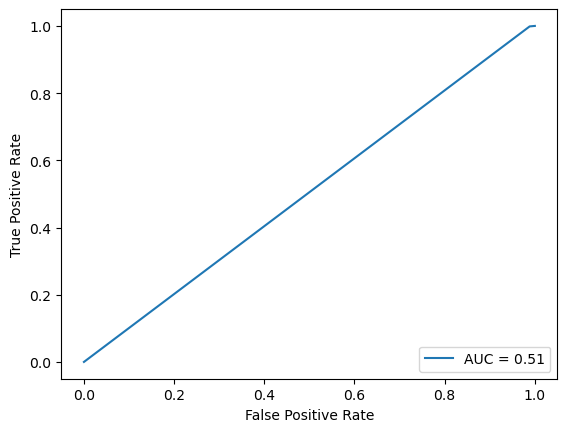

In [39]:
import matplotlib.pyplot as plt
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()